<a href="https://colab.research.google.com/github/hahoyeah/PPOA_-Competition/blob/main/PPoA_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM   # LSTM 층 
from sklearn.model_selection import train_test_split
import random
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from scipy import interpolate
import matplotlib.pyplot as plt


# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
tf.random.set_seed(19970119)
random.seed(19970119)
np.random.seed(19970119)

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

import folium

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive
!ls -al

/content/drive/MyDrive
total 325087
drwx------ 2 root root      4096 Jul 25 05:36  버스
drwx------ 2 root root      4096 Jul  4 05:29  영화
drwx------ 2 root root      4096 Jul 21 17:28  쇼핑
drwx------ 2 root root      4096 Aug  1 05:07  와인
drwx------ 2 root root      4096 Jul 13 05:22  따릉이
drwx------ 2 root root      4096 Jul  3 02:10  타이타닉
drwx------ 2 root root      4096 Sep  2 13:46  예측대회
drwx------ 2 root root      4096 Jul  6 06:06  구내식당
drwx------ 2 root root      4096 Jul  3 02:09  데분스터디
drwx------ 2 root root      4096 Sep  5  2019 '소프트웨어적 사고'
drwx------ 2 root root      4096 Aug  3 17:29  쇼핑몰평점
drwx------ 2 root root      4096 Aug 23 08:02  여행상품신청
drwx------ 2 root root      4096 Jun 29 05:58 '와인 (1)'
-rw------- 1 root root        68 Jul  2  2020  실습10.txt
-rw------- 1 root root     31960 May 18  2021 '1_4단질병성별연령10세구간별현황(진료년월).csv'
-rw------- 1 root root     31168 Jul  2  2020 '

In [ ]:
tr_path = './aT_data/data/train/'
ts_path = './aT_data/data/test/'

2280.8362756432366
2280.8362756432366
[4511.58   4469.0527 4848.499  4328.5767 4306.712  2159.521  3892.4087
 4063.368  2580.9893 4185.3467 3157.1326 5227.0244 2777.4912 3568.2559]
[4511.58   4469.0527 4848.499  4328.5767 4306.712  2159.521  3892.4087
 4063.368  2580.9893 4185.3467 3157.1326 5227.0244 2777.4912 3568.2559]
    datadate      단가(원)    거래량     거래대금(원)  경매건수    도매시장코드      도매법인코드  산지코드   \
0   20170101   6243.750  104.0   649649.70   2.0  240001.0  24000101.0  502.0   
1   20170102   6243.750  104.0   649649.70   2.0  240001.0  24000101.0  502.0   
2   20170103   7626.375  162.0  1313834.85   1.5  235002.0  23500201.5  422.5   
3   20170104   9009.000  220.0  1978020.00   1.0  230003.0  23000302.0  343.0   
4   20170105  10010.000   10.0    99900.00   1.0  230001.0  23000104.0  343.0   
5   20170106   5494.500   20.0   110110.00   1.0  350301.0  35030102.0  570.0   
6   20170107   9839.830   23.0   226226.00   2.0  371501.0  37150102.0  730.0   
7   20170108   2472.470  332

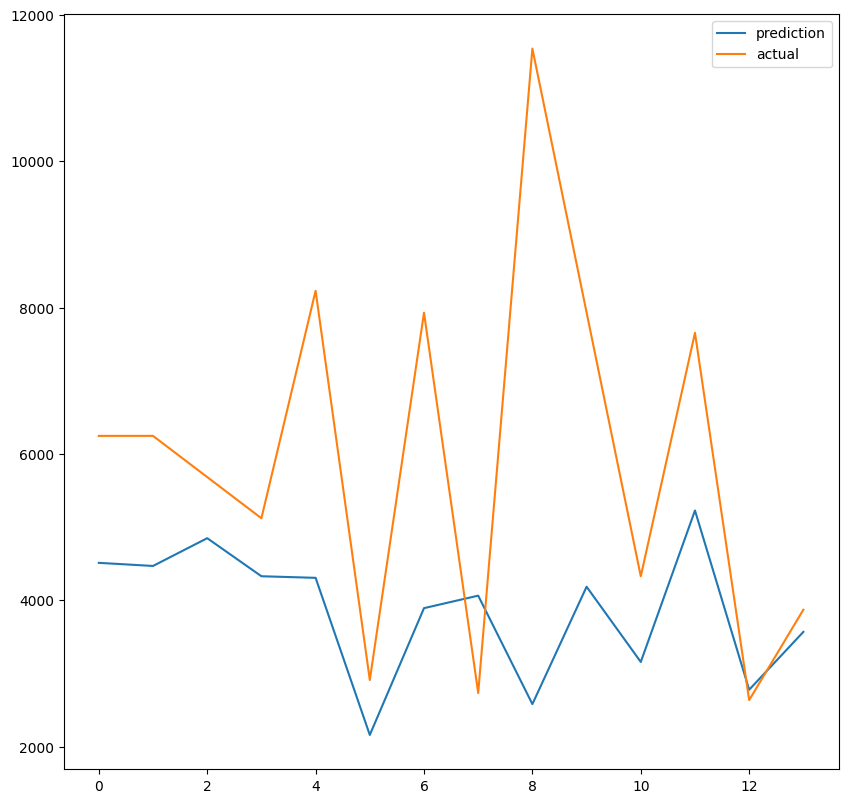

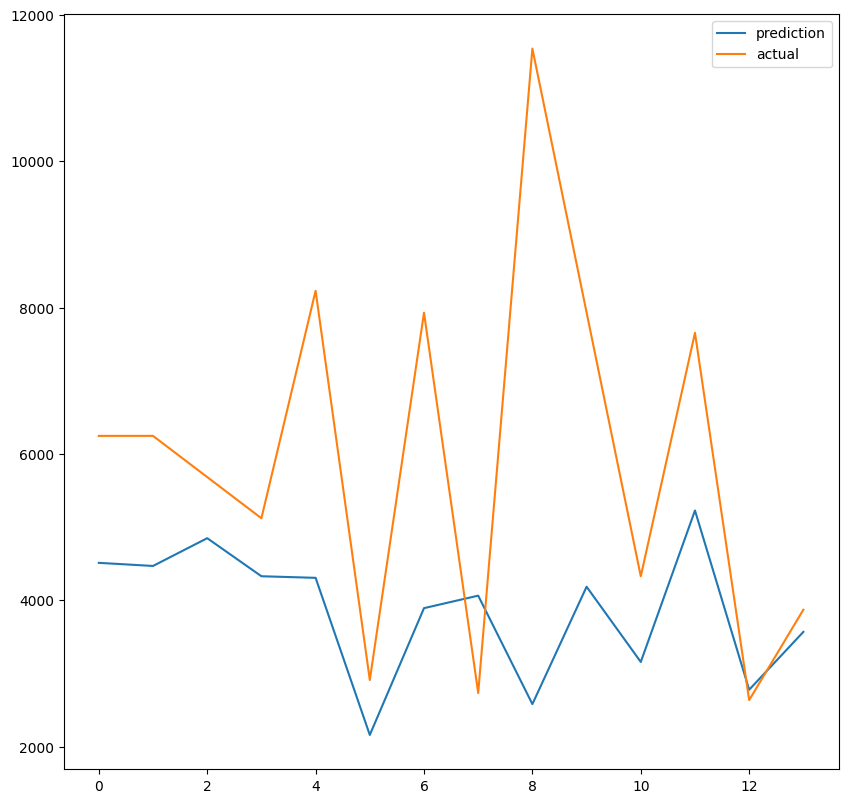

In [ ]:
class aaa:
    def __init__(self, tr_path, ts_path):
        # train, test 경로 설정
        self.tr_path = tr_path
        self.ts_path = ts_path
        
        # 품목 하나에 대하여 csv파일 불러오기
        self.df = pd.read_csv(self.tr_path + '/train_0.csv')
        self.dfT = pd.read_csv(self.ts_path + '/set_0/test_0.csv')



    # 결측치 채우기
        self.df = self.df.fillna(method='ffill') # 결측치 위치 기준 윗 값 가져오기 
        self.df = self.df.fillna(method='bfill') # 결측치 위치 기준 아랫 값 가져오기

        self.dfT = self.dfT.interpolate(method='values',kind='quadratic') # quadratic # df = df.interpolate(method='values')
        self.dfT = self.dfT.copy().replace([np.inf, -np.inf], np.nan)
        self.dfT = self.dfT.fillna(method='bfill') # 결측치 위치 기준 아랫 값 가져오기

    #     self.df = self.df.fillna(method='ffill') # 결측치 위치 기준 윗 값 가져오기 
    #     self.df = self.df.fillna(method='bfill') # 결측치 위치 기준 아랫 값 가져오기

    #     # 훈련 데이터 dropna로 결측치 제거하기
    #     # self.df = self.df.dropna()
    #     # self.df


    # # test 데이터
    # # 단가(원)이 결측치면 행 제거
    #     self.dfT = self.dfT.dropna(subset = ['단가(원)'])
    #     self.dfT['일자별_도매가격_최대(원)']
    #     # 결측치 위치 기준 아랫 값 가져오기
    #     self.dfT = self.dfT.fillna(method='bfill')
    #     self.dfT = self.dfT.fillna(method='ffill')
#################################################################################################

# 열맞추기
        self.check_col = ['일자구분_중순', '일자구분_초순', '일자구분_하순','월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', 
            '월구분_4월','월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'] # 열 개수 맞추기

        self.add_col = [i for i in self.check_col if i not in self.dfT.columns]
        for a in self.add_col:
            self.dfT[a] = 0

        self.dfT=self.dfT[['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
        '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
        '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
        '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
        '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
        '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
        '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_0_습도(%)', '주산지_1_초기온도(℃)',
        '주산지_1_최대온도(℃)', '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)',
        '주산지_1_습도(%)', '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)',
        '주산지_2_평균온도(℃)', '주산지_2_강수량(ml)', '주산지_2_습도(%)', '일자구분_중순', '일자구분_초순',
        '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월',
        '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월']]



    #  연도, 요일 피처 추가
        self.df['datetime'] = self.df['datadate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

        self.df['week_day'] = self.df['datetime'].dt.day_name()
        self.df['datetime'] = self.df['datetime'].astype(str)

        self.df['year'] = self.df['datetime'].apply(lambda x : x.split('-')[0]) #년

        self.df['year'] = self.df['year'].astype('int')
        
        self.df.loc[self.df['week_day'] == 'Sunday', 'week_day'] = 0
        self.df.loc[self.df['week_day'] == 'Monday', 'week_day'] = 1
        self.df.loc[self.df['week_day'] == 'Tuesday', 'week_day'] = 2
        self.df.loc[self.df['week_day'] == 'Wednesday', 'week_day'] = 3
        self.df.loc[self.df['week_day'] == 'Thursday', 'week_day'] = 4
        self.df.loc[self.df['week_day'] == 'Friday', 'week_day'] = 5
        self.df.loc[self.df['week_day'] == 'Saturday', 'week_day'] = 6

        self.dfT['datetime'] = self.dfT['datadate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
        self.dfT['week_day'] = self.dfT['datetime'].dt.day_name()
        self.dfT['datetime'] = self.dfT['datetime'].astype(str)
        self.dfT['year'] = self.dfT['datetime'].apply(lambda x : x.split('-')[0]) #년
        self.dfT['year'] = self.dfT['year'].astype('int')

        self.dfT.loc[self.dfT['week_day'] == 'Sunday', 'week_day'] = 0
        self.dfT.loc[self.dfT['week_day'] == 'Monday', 'week_day'] = 1
        self.dfT.loc[self.dfT['week_day'] == 'Tuesday', 'week_day'] = 2
        self.dfT.loc[self.dfT['week_day'] == 'Wednesday', 'week_day'] = 3
        self.dfT.loc[self.dfT['week_day'] == 'Thursday', 'week_day'] = 4
        self.dfT.loc[self.dfT['week_day'] == 'Friday', 'week_day'] = 5
        self.dfT.loc[self.dfT['week_day'] == 'Saturday', 'week_day'] = 6

        self.df=self.df.drop(columns = ['datetime'])
        self.dfT=self.dfT.drop(columns = ['datetime'])
#################################################################################################

        self.over_value = 20000
        self.over_value
        self.df = self.df[self.df['해당일자_전체평균가격(원)'] <= self.over_value]
        self.dfT = self.dfT[self.dfT['해당일자_전체평균가격(원)'] <= self.over_value]
#################################################################################################
    # 요일 원핫 인코딩
        self.df=pd.get_dummies(self.df,columns=['week_day'])
        self.dfT=pd.get_dummies(self.dfT,columns=['week_day'])




    # 요일 열 개수 맞추기
        self.wy_col = ['week_day_0', 'week_day_1','week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6']
        self.add_col = [i for i in self.wy_col if i not in self.dfT.columns]
        for a in self.add_col:
          self.dfT[a] = 0

        self.dfT=self.dfT[['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_0_습도(%)', '주산지_1_초기온도(℃)',
       '주산지_1_최대온도(℃)', '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)',
       '주산지_1_습도(%)', '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)',
       '주산지_2_평균온도(℃)', '주산지_2_강수량(ml)', '주산지_2_습도(%)', '일자구분_중순', '일자구분_초순',
       '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월',
       '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월','year','week_day_0', 'week_day_1','week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6']]


#################################################################################################

    # 날짜 재배열
        # 날짜 재 배열(train)
        self.date = pd.to_datetime(self.df['datadate'], format='%Y%m%d')
        self.df['datadate'] = self.date 
        # 날짜 재 배열(test)
        self.date_test = pd.to_datetime(self.dfT['datadate'], format='%Y%m%d')
        self.dfT['datadate'] = self.date_test


    
    # 피처추가
        self.df['differ'] = self.df['상위가격 평균가(원)'] - self.df['하위가격 평균가(원)']
        self.dfT['differ'] = self.dfT['상위가격 평균가(원)'] - self.dfT['하위가격 평균가(원)']

        self.df['plus'] = self.df['상위가격 평균가(원)']*self.df['상위가격 거래물량(kg)'] + self.df['하위가격 평균가(원)']*self.df['하위가격 거래물량(kg)']
        self.dfT['plus'] = self.dfT['상위가격 평균가(원)']*self.dfT['상위가격 거래물량(kg)'] + self.dfT['하위가격 평균가(원)']*self.dfT['하위가격 거래물량(kg)']

        self.df['kg_differ'] = self.df['상위가격 거래물량(kg)'] - self.df['하위가격 거래물량(kg)']
        self.dfT['kg_differ'] = self.dfT['상위가격 거래물량(kg)'] - self.dfT['하위가격 거래물량(kg)']

        self.df['m'] = self.df['상위가격 평균가(원)']*self.df['상위가격 거래물량(kg)'] - self.df['하위가격 평균가(원)']*self.df['하위가격 거래물량(kg)']
        self.dfT['m'] = self.dfT['상위가격 평균가(원)']*self.dfT['상위가격 거래물량(kg)'] - self.dfT['하위가격 평균가(원)']*self.dfT['하위가격 거래물량(kg)']

        self.df['sale_price'] = self.df['일자별_소매가격_평균(원)'] - self.df['일자별_도매가격_평균(원)']
        self.dfT['sale_price'] = self.dfT['일자별_소매가격_평균(원)'] - self.dfT['일자별_도매가격_평균(원)']

        # object_drop
        self.drop_li = []

        # object가 있는 테스트 컬럼 drop
        for i in range(0,70):
            if self.df.iloc[:,i].dtype == 'O':
                self.drop_li.append(i)
                
        self.df_list = list(self.df.columns)
        self.drop_li_n = []
        for i in self.drop_li:
            self.drop_li_n.append(self.df_list[i])

        self.df_list = [i for i in self.df_list if i not in self.drop_li_n]
        for name in ['datadate', '해당일자_전체평균가격(원)']:
            self.df_list.remove(name)
        


    # Normalization
        self.scaler = MinMaxScaler()
        # 드롭한 컴럼 리스트
        self.scale_cols = self.df_list
        
        # self.scale_cols_remove = self.scale_cols.remove('해당일자_전체평균가격(원)')
        # # 훈련 해당일자 컬럼 추출
        self.price_col_train = self.df['해당일자_전체평균가격(원)']
        # 테스트 해당일자 컬럼 추출
        self.price_col_test = self.dfT['해당일자_전체평균가격(원)']

        # Normalization(train)
        # train - 정규화 - 데이터프레임
        self.df_scaled = self.scaler.fit_transform(self.df[self.scale_cols])
        self.df_scaled = pd.DataFrame(self.df_scaled)
        self.df_scaled.columns = self.scale_cols
        self.df_scaled['해당일자_전체평균가격(원)'] = self.price_col_train

        
        

        # Normalization(test)
        self.scaler_ts = MinMaxScaler()
        self.scale_cols_ts = self.df_list
                        
        # ['일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_2월', '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'] not in index"  , '주산지_2_습도(%)'
        self.df_scaled_ts = self.scaler_ts.fit_transform(self.dfT[self.scale_cols_ts])
        self.df_scaled_ts = pd.DataFrame(self.df_scaled_ts)
        self.df_scaled_ts.columns = self.scale_cols_ts
        self.price_col_test_n = pd.Series(self.price_col_test.values)
        self.df_scaled_ts['해당일자_전체평균가격(원)'] = self.price_col_test_n        

        # 해당일자 열 추가


    def RandomForest_future(self):
        self.clf = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 3000, tree_method='gpu_hist')

        # 데이터 나누기
        self.X_train_ = self.df_scaled.drop(columns = '해당일자_전체평균가격(원)')
        self.y_train_ = self.df_scaled['해당일자_전체평균가격(원)']

        self.X_test = self.df_scaled_ts.drop(columns = '해당일자_전체평균가격(원)')
        self.y_test = self.df_scaled_ts['해당일자_전체평균가격(원)']


        # 2주 후 예측
        pred_days = 14
        self.X_train_2 = self.X_train_.iloc[:-pred_days]
        self.y_train_2 = self.y_train_.iloc[pred_days:]

        # ### 결측치가 남아있는 부분이 있어 채워줌
        self.X_train_ = self.X_train_.fillna(method='bfill')
        self.X_train_ = self.X_train_.fillna(method='ffill')

        self.y_train_ = self.y_train_.fillna(method='bfill')
        self.y_train_ = self.y_train_.fillna(method='ffill')

        # 학습
        self.clf.fit(self.X_train_, self.y_train_)


        # ### 결측치가 남아있는 부분이 있어 채워줌
        self.X_test = self.X_test.fillna(method='bfill')
        self.X_test = self.X_test.fillna(method='ffill')

        self.y_pred_ = self.clf.predict(self.X_test)
        y_pred_ = self.y_pred_

        # 평가지표
        MAE = mean_absolute_error(self.y_test, self.y_pred_)
        print(MAE)
        

        # 시각화
        self.y_test.index = range(14)

        self.fig = plt.figure(figsize = (10, 10), dpi = 100)
        self.ax = self.fig.subplots()

        self.ax.plot(self.y_pred_, label = 'prediction')
        self.ax.plot(self.y_test, label = 'actual')
        self.ax.legend()
        return y_pred_



# 학습에 사용할 정보와 예측하고자 하는 정보를 분리합니다.

    def RandomForest_present(self):
        self.clf = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 3000, tree_method='gpu_hist')


        # 데이터 나누기
        self.X_train_ = self.df_scaled.drop(columns = '해당일자_전체평균가격(원)')
        self.y_train_ = self.df_scaled['해당일자_전체평균가격(원)']

        self.X_test = self.df_scaled_ts.drop(columns = '해당일자_전체평균가격(원)')
        self.y_test = self.df_scaled_ts['해당일자_전체평균가격(원)']


        # 2주 후 예측
        pred_days = 14
        self.X_train_2 = self.X_train_
        self.y_train_2 = self.y_train_

        ## 결측치가 남아있는 부분이 있어 채워줌
        self.X_train_ = self.X_train_.fillna(method='bfill')
        self.X_train_ = self.X_train_.fillna(method='ffill')

        self.y_train_ = self.y_train_.fillna(method='bfill')
        self.y_train_ = self.y_train_.fillna(method='ffill')       #############################################################  

        # 학습
        self.clf.fit(self.X_train_, self.y_train_)


        ## 결측치가 남아있는 부분이 있어 채워줌
        self.X_test = self.X_test.fillna(method='bfill')
        self.X_test = self.X_test.fillna(method='ffill')

        self.y_pred_ = self.clf.predict(self.X_test)
        y_pred_ = self.y_pred_

        # 평가지표
        MAE = mean_absolute_error(self.y_test, self.y_pred_)
        print(MAE)
        

        # 시각화
        self.y_test.index = range(14)

        self.fig = plt.figure(figsize = (10, 10), dpi = 100)
        self.ax = self.fig.subplots()

        self.ax.plot(self.y_pred_, label = 'prediction')
        self.ax.plot(self.y_test, label = 'actual')
        self.ax.legend()
        return y_pred_



    def Prophet(self):
        self.da = self.date.tolist()
        
        self.df = pd.DataFrame(data=[self.da, self.df_scaled['해당일자_전체평균가격(원)']]).T
        self.df.columns = ['ds', 'y']
        self.df.index = self.da






a1 = aaa('./aT_data/data/train', './aT_data/data/test')

a_future = a1.RandomForest_future()
a_present = a1.RandomForest_present()

print(a_future)
print(a_present)
print(dfT)